In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ppm = PyramidPooling(
            16, [16, 6, 3, 2, 1], 16, 16
        )
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(7936, 3968)
        self.fc_2 = nn.Linear(3968, 3)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout1d(p=0.2, inplace=False)
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.ppm(x)
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(self.dropout(x))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─PyramidPooling: 1-3                    [64, 31, 16, 16]          --
│    └─AdaptiveAvgPool2d: 2-5            [64, 16, 16, 16]          --
│    └─conv2DBatchNormRelu: 2-6          [64, 3, 16, 16]           --
│    │    └─Conv2d: 3-1                  [64, 3, 16, 16]           48
│    │    └─BatchNorm2d: 3-2             [64, 3, 16, 16]           6
│    │    └─ReLU: 3-3                    [64, 3, 16, 16]           --
│    │    └─Dro

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.41it/s]


val Loss: 1.1066 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 2.8201 Acc: 0.4084


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.19it/s]


val Loss: 1.8329 Acc: 0.3338
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


train Loss: 1.0095 Acc: 0.4935


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.44it/s]


val Loss: 1.2568 Acc: 0.4067
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.9713 Acc: 0.5145


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.49it/s]


val Loss: 0.9138 Acc: 0.6405
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


train Loss: 0.9371 Acc: 0.5285


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.48it/s]


val Loss: 0.9046 Acc: 0.5857
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


train Loss: 0.9136 Acc: 0.5626


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.49it/s]


val Loss: 0.9399 Acc: 0.4829
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.8654 Acc: 0.5836


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.57it/s]


val Loss: 0.8955 Acc: 0.5733
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


train Loss: 0.8554 Acc: 0.5986


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.50it/s]


val Loss: 1.0492 Acc: 0.4414
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


train Loss: 0.8501 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.62it/s]


val Loss: 1.0535 Acc: 0.4671
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


train Loss: 0.7999 Acc: 0.6186


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.22it/s]


val Loss: 0.8463 Acc: 0.5986
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


train Loss: 0.8002 Acc: 0.6366


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.18it/s]


val Loss: 0.7492 Acc: 0.6714
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.7577 Acc: 0.6476


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


val Loss: 0.8724 Acc: 0.5643
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7791 Acc: 0.6396


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.25it/s]


val Loss: 0.7770 Acc: 0.6481
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.7480 Acc: 0.6406


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.29it/s]


val Loss: 0.8893 Acc: 0.5690
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


train Loss: 0.7405 Acc: 0.6386


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.32it/s]


val Loss: 0.7794 Acc: 0.6871
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


train Loss: 0.7650 Acc: 0.6336


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.34it/s]


val Loss: 0.9791 Acc: 0.5229
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


train Loss: 0.6846 Acc: 0.6827


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.33it/s]


val Loss: 0.7765 Acc: 0.6433
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


train Loss: 0.7028 Acc: 0.6577


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.35it/s]


val Loss: 0.7844 Acc: 0.6452
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


train Loss: 0.6595 Acc: 0.6677


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.33it/s]


val Loss: 0.7496 Acc: 0.6562
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


train Loss: 0.6590 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.34it/s]


val Loss: 0.8109 Acc: 0.6243
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


train Loss: 0.6176 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.04it/s]


val Loss: 0.7589 Acc: 0.6719
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.6825 Acc: 0.6807


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.50it/s]


val Loss: 0.8438 Acc: 0.6105
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.6083 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.83it/s]


val Loss: 0.9020 Acc: 0.5895
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6226 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.77it/s]


val Loss: 0.7845 Acc: 0.6524
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.6371 Acc: 0.6957


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.79it/s]


val Loss: 0.9906 Acc: 0.5771
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


train Loss: 0.5759 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.82it/s]


val Loss: 1.0884 Acc: 0.5700
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.6349 Acc: 0.6967


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.70it/s]


val Loss: 0.7939 Acc: 0.6900
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.5384 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.12it/s]


val Loss: 0.7315 Acc: 0.7138
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.5631 Acc: 0.7407


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.68it/s]


val Loss: 0.7635 Acc: 0.6757
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.5735 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.9649 Acc: 0.5848
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.5260 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.79it/s]


val Loss: 0.7825 Acc: 0.7019
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


train Loss: 0.4812 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.66it/s]


val Loss: 1.1563 Acc: 0.6019
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.5077 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.80it/s]


val Loss: 0.8011 Acc: 0.6743
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.4920 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.76it/s]


val Loss: 0.7462 Acc: 0.7071
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.4165 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.76it/s]


val Loss: 0.9841 Acc: 0.6386
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.4406 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.7343 Acc: 0.7033
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.4200 Acc: 0.8098


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.75it/s]


val Loss: 0.7452 Acc: 0.6833
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.3733 Acc: 0.8218


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8449 Acc: 0.6795
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.5216 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.38it/s]


val Loss: 0.8598 Acc: 0.6710
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.3544 Acc: 0.8298


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.9679 Acc: 0.6648
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.4074 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.75it/s]


val Loss: 1.1772 Acc: 0.6110
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.3714 Acc: 0.8168


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.77it/s]


val Loss: 1.1559 Acc: 0.6271
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.3644 Acc: 0.8188


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.73it/s]


val Loss: 1.0785 Acc: 0.6600
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.3127 Acc: 0.8348


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.82it/s]


val Loss: 1.0862 Acc: 0.6590
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.3254 Acc: 0.8328


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.79it/s]


val Loss: 0.8742 Acc: 0.7043
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.3109 Acc: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.70it/s]


val Loss: 1.2681 Acc: 0.6433
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.3459 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.46it/s]


val Loss: 1.2054 Acc: 0.6105
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.3492 Acc: 0.8308


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.43it/s]


val Loss: 0.9265 Acc: 0.6824
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.3032 Acc: 0.8338


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.40it/s]


val Loss: 1.0806 Acc: 0.6705
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.2619 Acc: 0.8609


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.44it/s]


val Loss: 0.9694 Acc: 0.6995


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

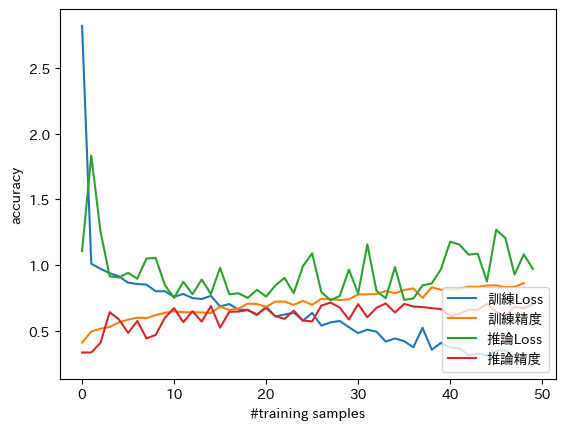

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

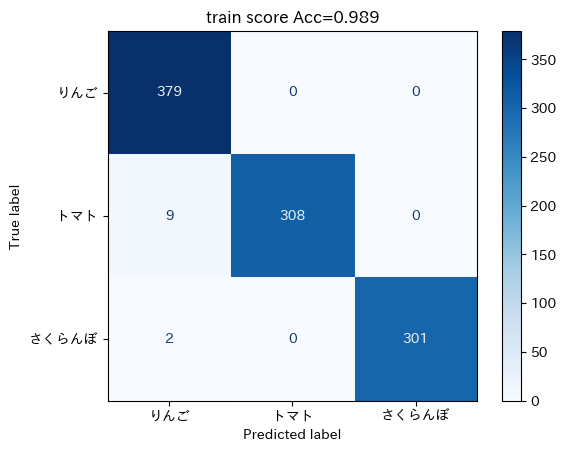

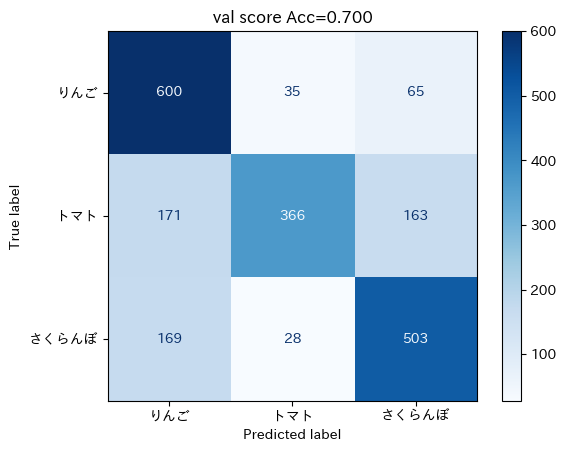

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

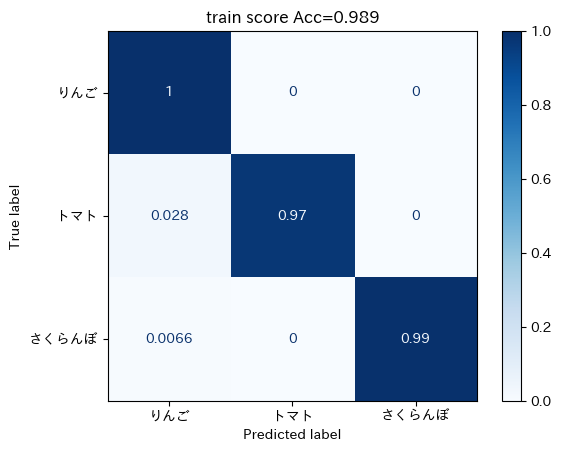

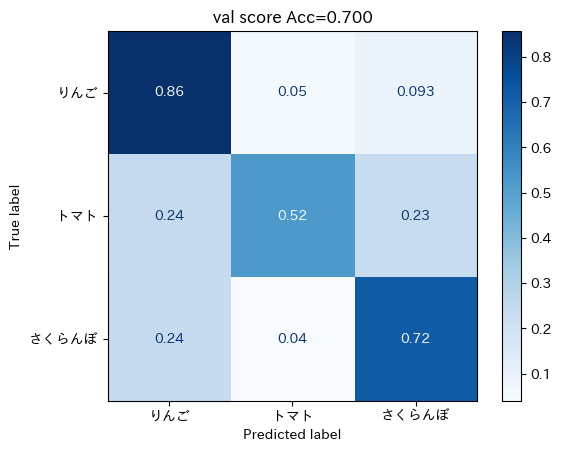

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()